In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
tf.random.set_seed(0)
np.random.seed(0)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1409232426787635934
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2986082304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16611687693556204000
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-09-07 10:10:57.707314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 10:10:57.707932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 10:10:57.708400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
num_samples = 10000
num_dimensions = 30

# Generate random samples
raw_data = np.random.rand(num_samples, num_dimensions)

outlier_indices_1 = [0,1,2,3,4,5,6]
outlyin_amount_1 = 20
outlier_indices_2 = [0,2,4,6,8,10,12]
outlyin_amount_2 = 10
outlier_indices_3 = [0,3,6,9,12,15,18]
outlyin_amount_3 = 5
outlier_indices_4 = [0,4,8,12,16,20,24]
outlyin_amount_4 = 2
outlier_indices_5 = [0,5,10,15,20,25,29]
outlyin_amount_5 = 1.1
outlier_indices_6 = [0,1,2,3,4,5,6]
outlyin_amount_6 = [20,15,10,5,2,1.1,1.05]

corrupted_data = raw_data

corrupted_data[100:120, outlier_indices_1] = outlyin_amount_1
corrupted_data[200:220, outlier_indices_2] = outlyin_amount_2
corrupted_data[300:320, outlier_indices_3] = outlyin_amount_3
corrupted_data[400:420, outlier_indices_4] = outlyin_amount_4
corrupted_data[500:520, outlier_indices_5] = outlyin_amount_5
corrupted_data[600:620, outlier_indices_6] = outlyin_amount_6

for outlier_gene_index in range(corrupted_data.shape[1]+1):
    corrupted_data[700+outlier_gene_index,:outlier_gene_index] = outlyin_amount_1
    
normalized_arr = (corrupted_data - np.min(corrupted_data,axis = 0)) / (np.max(corrupted_data,axis = 0) - np.min(corrupted_data,axis = 0))

# print(raw_data)

In [15]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 2

encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(30, activation="tanh")(encoder_inputs)
x = layers.Dense(20, activation="tanh")(x)
x = layers.Dense(18, activation="tanh")(x)
x = layers.Dense(16, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(16, activation="tanh")(latent_inputs)
x = layers.Dense(18, activation="tanh")(x)
x = layers.Dense(20, activation="tanh")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.15 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

creditdata = np.concatenate([normalized_arr], axis=0)
creditdata = np.expand_dims(creditdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
history = vae.fit(creditdata, epochs=100, batch_size=256)

Epoch 1/100
40/40 [==============================] - 3s 4ms/step - loss: 0.0270 - reconstruction_loss: 0.0156 - kl_loss: 0.0034
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0036 - reconstruction_loss: 0.0033 - kl_loss: 2.8397e-04
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0028 - reconstruction_loss: 0.0027 - kl_loss: 8.0875e-05 
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0029 - reconstruction_loss: 0.0029 - kl_loss: 4.7887e-05
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0024 - reconstruction_loss: 0.0025 - kl_loss: 3.3923e-05
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0023 - reconstruction_loss: 0.0024 - kl_loss: 2.4802e-05 
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0023 - reconstruction_loss: 0.0024 - kl_loss: 1.9132e-05 
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.00

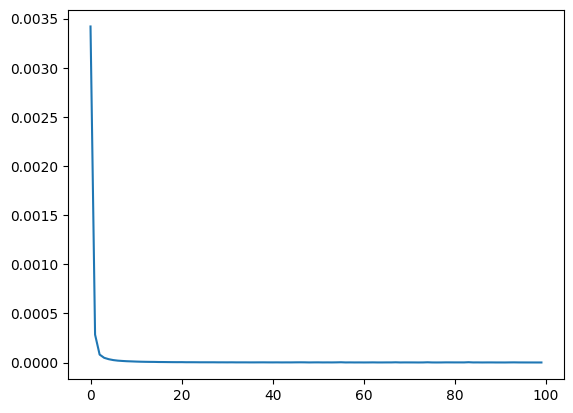

In [17]:
plt.plot(history.history["kl_loss"])

In [6]:
inliers = corrupted_data[5:80,:]
mean_data = np.mean(corrupted_data, axis=0)
outlier1 = corrupted_data[101,:]



# #------------------ replacing the genes here ---------------------

# inliers[:,1] = mean_data[1]

# outlier1[1] = mean_data[1]

# # ----------------------------------------------------------------

mean_mean = []

for step in range(10):

    mean_data = mean_data.reshape([1,30])

    z_mean, z_log_var, z = vae.encoder(mean_data)
    reconstruction = vae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(mean_data,reconstruction)

    print(reconstruction_loss.numpy())
    
    mean_mean.append(reconstruction_loss.numpy())

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

84.47596
84.47679
84.478
84.47864
84.47622
84.482574
84.47655
84.47663
84.47732
84.47903
MEAN_MEAN =  84.47777
std_MEAN =  0.0018735796


In [5]:
mean_mean = []

for step in range(10):

    mean_ins_error = []

    for index in range(inliers.shape[0]):

        cand = inliers[index,:]

        cand = cand.reshape([1,30])

        mean_data = mean_data.reshape([1,30])

        z_mean, z_log_var, z = vae.encoder(cand)
        reconstruction = vae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(cand,reconstruction)

        mean_ins_error.append(reconstruction_loss.numpy())

    #     print("MEAN", index, " = ", reconstruction_loss.numpy())

    mean_ins_error = np.array(mean_ins_error)
    print("mean = ", np.mean(mean_ins_error))
    
    mean_mean.append(np.mean(mean_ins_error))
    

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

mean =  0.08685019
mean =  0.0860827
mean =  0.086468294
mean =  0.086056724
mean =  0.0910867
mean =  0.08703793
mean =  0.08570242
mean =  0.08692093
mean =  0.08628608
mean =  0.08673436
MEAN_MEAN =  0.08692263
std_MEAN =  0.0014473866


In [38]:
def fit_test(solution): 
       
    inliers = corrupted_data[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,30])
    
    particle = corrupted_data[101,:]
    particle = particle.reshape([1,30])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
        
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])
        
        in_normal_subspace = solution
        in_bad_subspace = 1 - solution        
        
        in_remain = candidate_inlier * in_normal_subspace
        

        
        in_replace = in_bad_subspace * avg_ins
        
        in_candidate = in_remain + in_replace
        
        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)
        
        
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        
        avg_in_rec.append(rec_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
        
        
    
    

#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_normal_subspace = solution
    out_bad_subspace = 1 - solution
    
    out_remain = particle * out_normal_subspace
    

    
    out_replace = avg_ins * out_bad_subspace
    
    out_candidate = out_remain + out_replace
    
    
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()
    
    fitness = rec_loss / avg_in_rec
    
    return -fitness



def fitness_func_avg(ga_instance, solution, solution_idx):
    
    fit_mean = []

    for i in range(10):
        fit_mean.append(fit_test(solution))

    return np.mean(np.array(fit_mean))

def on_generation(ga):
    print("Generation", ga.generations_completed)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
#     wandb.log({"solution_fitness": solution_fitness})
    
    print(solution_fitness)


    
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="my-project-dual-test",
    
#     # track hyperparameters and run metadata
# #     config={
# #     "learning_rate": 0.02,
# #     "architecture": "CNN",
# #     "dataset": "CIFAR-100",
# #     "epochs": 20,
# #     }
# )

fitness_function = fitness_func_avg

num_generations = 40
num_parents_mating = 2

sol_per_pop = 10
num_genes = corrupted_data.shape[1]

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

space = [[0,1] for i in range(num_genes)]

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10
keep_elitism = 5

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
#                        keep_parents=keep_parents,
                       keep_elitism = keep_elitism,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       gene_space = space)

In [39]:
ga_instance.run()
# wandb.finish()

Generation 1
-409.7479
Generation 2
-406.71332
Generation 3
-398.761
Generation 4
-376.8354
Generation 5
-212.04866
Generation 6
-207.36613
Generation 7
-196.63754
Generation 8
-193.98148
Generation 9
-196.03761
Generation 10
-196.03761
Generation 11
-196.03761
Generation 12
-196.03761
Generation 13
-196.03761
Generation 14
-196.03761
Generation 15
-192.92493
Generation 16
-0.6934384
Generation 17
-0.70246756
Generation 18
-0.5470918
Generation 19
-0.51984453
Generation 20
-0.51874584
Generation 21
-0.38416567
Generation 22
-0.41924635
Generation 23
-0.41924635
Generation 24
-0.41924635
Generation 25
-0.41924635
Generation 26
-0.41924635
Generation 27
-0.41924635
Generation 28
-0.41924635
Generation 29
-0.41924635
Generation 30
-0.41924635
Generation 31
-0.41924635
Generation 32
-0.41924635
Generation 33
-0.41924635
Generation 34
-0.41924635
Generation 35
-0.41924635
Generation 36
-0.41924635
Generation 37
-0.41924635
Generation 38
-0.41924635
Generation 39
-0.41924635
Generation 40
-0

In [40]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1.]
Fitness value of the best solution = -0.4192463457584381


In [35]:
# candid_sol = np.ones([1,30])
# candid_sol[0,outlier_indices_1] = 0
# # print(fit_test(solution))

# sol_mean = []
# candid_sol_mean = []

# for i in range(100):
#     sol_mean.append(fit_test(solution))
# print(np.mean(np.array(sol_mean)))

# for i in range(100):
#     candid_sol_mean.append(fit_test(candid_sol))
# print(np.mean(np.array(candid_sol_mean)))

-0.6686041
-0.7054567


# For Loop for Genetic Algorithm

In [6]:
best_solutions = []

wandb.init(
    # set the wandb project where this run will be logged
    project="VAE_Outlier_GA_Dual_Test_1",
    
    # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 20,
#     }
)

for out_indexing in range(1,corrupted_data.shape[1]+1):
    
    def fit_test(solution): 

        inliers = corrupted_data[10:13,:]

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,30])

        particle = corrupted_data[700+out_indexing,:]
        particle = particle.reshape([1,30])

    #     abn_subspace = solution * val_features[6728,:]

    #     abn_subspace = abn_subspace.reshape([1,30])

        avg_in_rec = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,30])

            in_normal_subspace = solution
            in_bad_subspace = 1 - solution        

            in_remain = candidate_inlier * in_normal_subspace



            in_replace = in_bad_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z_mean, z_log_var, z = vae.encoder(in_candidate)
            in_candidate_rec = vae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

            avg_in_rec.append(rec_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_normal_subspace = solution
        out_bad_subspace = 1 - solution

        out_remain = particle * out_normal_subspace



        out_replace = avg_ins * out_bad_subspace

        out_candidate = out_remain + out_replace


        z_mean, z_log_var, z = vae.encoder(out_candidate)
        out_candidate_rec = vae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        fitness = avg_in_rec / rec_loss

        return fitness



    def fitness_func_avg(ga_instance, solution, solution_idx):

        fit_mean = []

        for i in range(10):
            fit_mean.append(fit_test(solution))

        return np.mean(np.array(fit_mean))

    def on_generation(ga):
        print("Generation", ga.generations_completed)

        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        
        wandb.log({"GA - " + str(out_indexing) + "/solution_fitness": solution_fitness})

        print(solution_fitness)


    fitness_function = fitness_func_avg

    num_generations = 40
    num_parents_mating = 2

    sol_per_pop = 10
    num_genes = corrupted_data.shape[1]

    init_range_low = -2
    init_range_high = 5

    parent_selection_type = "sss"
    keep_parents = 1

    space = [[0,1] for i in range(num_genes)]

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
#                            keep_elitism=2,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           on_generation=on_generation,
                           gene_space = space)

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("##########  End of the ", out_indexing, " epoch ##########")
    print("Parameters of the best solution : {solution}".format(solution=solution))

    best_solutions.append(solution)
    
    sample = corrupted_data[700+out_indexing,:]
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for gene_no in range(30):
        
        if ((sample[gene_no] != 20) and (solution[gene_no] == 1)):
            
            TP = TP + 1
        
        elif (sample[gene_no] == 20) and (solution[gene_no] == 1):
            
            FP = FP + 1
            
        elif (sample[gene_no] == 20) and (solution[gene_no] == 0):
            
            TN = TN + 1
            
        elif (sample[gene_no] != 20) and (solution[gene_no] == 0):
            
            FN = FN + 1
    
    precision = TP / (TP + FP)

    recall = TP / (TP + FN)

    F1 = 2 * (precision * recall)/(precision + recall)
    
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    wandb.log({"Metrics/precision": precision, 
               "Metrics/recall": recall,
               "Metrics/F1": F1,
               "Metrics/MCC": MCC,
               "Metrics/num": out_indexing})
    
best_solutions = np.array(best_solutions)
np.save('best_solutions.npy', best_solutions)

GA - 1/solution_fitness,▁▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇
GA - 10/solution_fitness,▁▂▆▆▆▆▆▆████████████████████████████████
GA - 11/solution_fitness,▁▁▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████████████
GA - 12/solution_fitness,▁▁▁▂▂▄▄▅▄███████████████████████████████
GA - 13/solution_fitness,▁▅▅▅████████████████████████████████████
GA - 14/solution_fitness,▁███████████████████████████████████████
GA - 15/solution_fitness,▁▁▂▃▄▄▆▆▆▆▆▆████████████████████████████
GA - 16/solution_fitness,▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅█████████████
GA - 17/solution_fitness,▁▅▆▆▆▆▆▆▆███████████████████████████████
GA - 18/solution_fitness,▁▁▃▂▄▃▅▅▅▆▆▆▆▆▆▆████████████████████████
GA - 19/solution_fitness,▁▁▂▄▄▄▄▆▆███████████████████████████████


Generation 1
1.5674512
Generation 2
1.5993288
Generation 3
1.6315184
Generation 4
1.6483705
Generation 5
1.729442
Generation 6
1.8878481
Generation 7
2.0374985
Generation 8
2.0374985
Generation 9
2.0374985
Generation 10
2.0374985
Generation 11
2.170223
Generation 12
2.170223
Generation 13
2.170223
Generation 14
2.170223
Generation 15
2.170223
Generation 16
2.4822412
Generation 17
2.4822412
Generation 18
2.4822412
Generation 19
2.4822412
Generation 20
2.4822412
Generation 21
2.4822412
Generation 22
2.4822412
Generation 23
2.4822412
Generation 24
2.4822412
Generation 25
2.4822412
Generation 26
2.4822412
Generation 27
2.4822412
Generation 28
2.4822412
Generation 29
2.4822412
Generation 30
2.4822412
Generation 31
2.4822412
Generation 32
2.4822412
Generation 33
2.4822412
Generation 34
2.4822412
Generation 35
2.4822412
Generation 36
2.4822412
Generation 37
2.4822412
Generation 38
2.4822412
Generation 39
2.4822412
Generation 40
2.4822412
##########  End of the  1  epoch ##########
Parameters 

1.270424
Generation 16
1.270424
Generation 17
1.270424
Generation 18
1.270424
Generation 19
1.270424
Generation 20
1.3556899
Generation 21
1.4353596
Generation 22
1.4353596
Generation 23
1.4353596
Generation 24
1.4353596
Generation 25
1.4353596
Generation 26
1.4353596
Generation 27
1.4353596
Generation 28
1.4353596
Generation 29
1.4353596
Generation 30
1.4353596
Generation 31
1.5269808
Generation 32
1.7274355
Generation 33
1.4353596
Generation 34
1.4353596
Generation 35
1.4353596
Generation 36
1.4353596
Generation 37
1.4353596
Generation 38
1.4353596
Generation 39
1.4353596
Generation 40
1.4353596
##########  End of the  8  epoch ##########
Parameters of the best solution : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 0. 0.]
Generation 1
0.0039938046
Generation 2
0.004290007
Generation 3
0.9432575
Generation 4
0.9276142
Generation 5
0.9276142
Generation 6
0.9276142
Generation 7
1.0131066
Generation 8
1.2763135
Generation 9
1.1307032
Generation 1

Generation 24
1.2903092
Generation 25
1.2903092
Generation 26
1.2903092
Generation 27
1.2903092
Generation 28
1.2903092
Generation 29
1.2903092
Generation 30
1.2903092
Generation 31
1.2903092
Generation 32
1.2903092
Generation 33
1.2903092
Generation 34
1.2903092
Generation 35
1.2903092
Generation 36
1.2903092
Generation 37
1.2903092
Generation 38
1.2903092
Generation 39
1.2903092
Generation 40
1.2903092
##########  End of the  15  epoch ##########
Parameters of the best solution : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 0.]
Generation 1
0.0008334817
Generation 2
0.000993399
Generation 3
0.0009802824
Generation 4
0.00147432
Generation 5
0.0019230017
Generation 6
0.0019000417
Generation 7
0.00345244
Generation 8
0.0035133585
Generation 9
0.0038445275
Generation 10
0.0037039313
Generation 11
0.0037039313
Generation 12
0.0037039313
Generation 13
0.0037039313
Generation 14
0.0038744442
Generation 15
0.0038507872
Generation 16
0.7472664
Gener

0.001793877
Generation 16
0.0018581845
Generation 17
0.0018628568
Generation 18
0.003621539
Generation 19
0.0035595607
Generation 20
0.0035595607
Generation 21
0.0035595607
Generation 22
0.0035595607
Generation 23
0.0035595607
Generation 24
0.0035595607
Generation 25
0.0035595607
Generation 26
0.0035595607
Generation 27
0.0035595607
Generation 28
0.0035595607
Generation 29
0.0035595607
Generation 30
0.0035595607
Generation 31
0.0035595607
Generation 32
0.0035595607
Generation 33
0.0035595607
Generation 34
0.0035595607
Generation 35
0.0035595607
Generation 36
0.0035595607
Generation 37
0.0035595607
Generation 38
0.003577048
Generation 39
0.0035595607
Generation 40
0.0035595607
##########  End of the  22  epoch ##########
Parameters of the best solution : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1.]
Generation 1
0.00053816696
Generation 2
0.00077317155
Generation 3
0.00090683403
Generation 4
0.00082632154
Generation 5
0.00082632154
Generati

Generation 1
0.000500976
Generation 2
0.0005072182
Generation 3
0.00049049885
Generation 4
0.00049049885
Generation 5
0.0005138705
Generation 6
0.00063286367
Generation 7
0.0006002371
Generation 8
0.00073452573
Generation 9
0.00076714996
Generation 10
0.00076714996
Generation 11
0.00076714996
Generation 12
0.0007904769
Generation 13
0.0007689132
Generation 14
0.0007689132
Generation 15
0.0007689132
Generation 16
0.0007726362
Generation 17
0.0007689132
Generation 18
0.00080911804
Generation 19
0.0007689132
Generation 20
0.0007689132
Generation 21
0.0007689132
Generation 22
0.0007689132
Generation 23
0.0007689132
Generation 24
0.0007689132
Generation 25
0.0007689132
Generation 26
0.0007689132
Generation 27
0.0007689132
Generation 28
0.0007689132
Generation 29
0.0007689132
Generation 30
0.0007689132
Generation 31
0.0007689132
Generation 32
0.0007689132
Generation 33
0.0007689132
Generation 34
0.0007689132
Generation 35
0.0009943868
Generation 36
0.0011545974
Generation 37
0.001110062
Gene

ZeroDivisionError: division by zero

In [24]:
def fit_test(solution): 
       
    inliers = normalized_arr[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,30])
    
    particle = normalized_arr[101,:]
    particle = particle.reshape([1,30])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
        
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])
        
        in_normal_subspace = solution
        in_bad_subspace = 1 - solution        
        
        in_remain = candidate_inlier * in_normal_subspace
        

        
        in_replace = in_bad_subspace * avg_ins
        
        in_candidate = in_remain + in_replace
        
        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)
        
        
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        
        avg_in_rec.append(rec_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
        
        
    
    

#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_normal_subspace = solution
    out_bad_subspace = 1 - solution
    
    out_remain = particle * out_normal_subspace
    

    
    out_replace = avg_ins * out_bad_subspace
    
    out_candidate = out_remain + out_replace
    
    
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()
    
    fitness = rec_loss / avg_in_rec
    
    return -fitness

In [32]:
sol = np.ones([1,30])
sol_fitness = []
for i in range(1000):
    # print(np.abs(fit_test(sol)))
    sol_fitness.append(np.abs(fit_test(sol)))

sol_fitness_0 = np.array(sol_fitness)

print(np.mean(sol_fitness))
print(np.std(sol_fitness))

948.20685
53.95069


In [33]:
sol = np.ones([1,30])
sol[0,0] = 0
sol_fitness = []
for i in range(1000):
    # print(np.abs(fit_test(sol)))
    sol_fitness.append(np.abs(fit_test(sol)))

sol_fitness_1 = np.array(sol_fitness)

print(np.mean(sol_fitness))
print(np.std(sol_fitness))

849.51874
49.418495


In [22]:
sol = np.ones([1,30])
sol[0,0] = 0
sol[0,1] = 0
sol[0,2] = 0

total_rec = []

particle = normalized_arr[101,:]
particle = particle.reshape([1,30])


inliers = normalized_arr[10:13,:]
    
avg_ins = np.mean(inliers, axis=0)
avg_ins = avg_ins.reshape([1,30])


out_normal_subspace = sol
out_bad_subspace = 1 - sol

out_remain = particle * out_normal_subspace



out_replace = avg_ins * out_bad_subspace

out_candidate = out_remain + out_replace

for i in range(1000):
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()

    total_rec.append(rec_loss)

total_rec = np.array(total_rec)

print(np.mean(total_rec))
print(np.std(total_rec))

    


0.12518701
0.0011377578


In [16]:
out_bad_subspace

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
z_mean, z_log_var, z = vae.encoder(particle)
reconstructed = vae.decoder(z)

rec_loss = tf.keras.losses.MeanSquaredError()(reconstructed,particle)
rec_loss = rec_loss.numpy()
print(particle)
print(reconstructed)
print(rec_loss)

[[1.         1.         1.         1.         1.         1.
  1.         0.00297515 0.01510315 0.03385247 0.02889087 0.01653609
  0.0416705  0.01380664 0.01302149 0.02799379 0.0239093  0.02229641
  0.00778653 0.0252289  0.01294949 0.01959757 0.03666489 0.04683846
  0.03869174 0.02028072 0.02964397 0.03732108 0.02070391 0.01801135]]
tf.Tensor(
[[0.0348127  0.02434092 0.03297227 0.0296979  0.02301956 0.02120499
  0.01868577 0.02015038 0.03088838 0.03234825 0.03234005 0.03642559
  0.02926851 0.02185646 0.02128324 0.03174393 0.0235996  0.03306892
  0.02981786 0.02041823 0.01804982 0.02450623 0.02639421 0.02664656
  0.03106015 0.01795425 0.0231435  0.02068016 0.01900377 0.0202697 ]], shape=(1, 30), dtype=float32)
0.2212822565309322


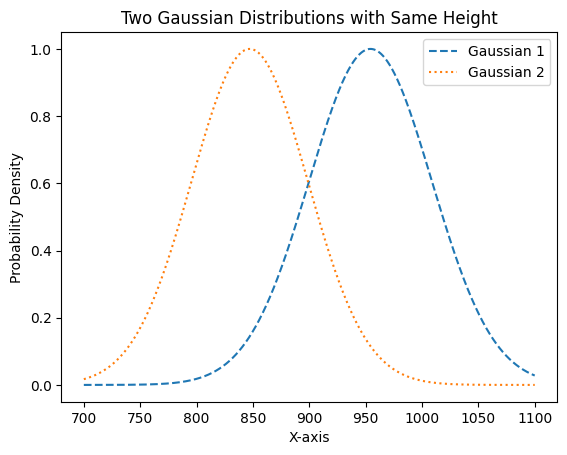

In [30]:
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the Gaussian distributions
mu1, sigma1 = 954.3, 54.47  # Mean and standard deviation for the first Gaussian
mu2, sigma2 = 847.13, 51.57  # Mean and standard deviation for the second Gaussian
height = 1.0  # Height of both Gaussian distributions

# Generate data points for the x-axis
x = np.linspace(700, 1100, 10000)

# Calculate the probability density functions (PDFs) for the two Gaussians
pdf1 = norm.pdf(x, mu1, sigma1)
pdf2 = norm.pdf(x, mu2, sigma2)

# Scale the PDFs to have the same height
pdf1 *= height / pdf1.max()
pdf2 *= height / pdf2.max()

# Plot the two Gaussian distributions
plt.plot(x, pdf1, label='Gaussian 1', linestyle='dashed')
plt.plot(x, pdf2, label='Gaussian 2', linestyle='dotted')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Two Gaussian Distributions with Same Height')

# Add legend
plt.legend()

# Show the plot
plt.show()


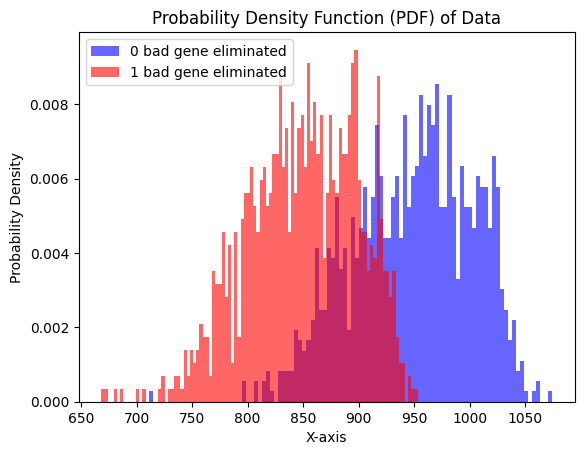

In [34]:
plt.hist(sol_fitness_0, bins=100, density=True, alpha=0.6, color='b', label='0 bad gene eliminated')
plt.hist(sol_fitness_1, bins=100, density=True, alpha=0.6, color='r', label='1 bad gene eliminated')
# Customize labels and title
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF) of Data')

# Show the plot
plt.legend()
plt.show()